Dataset source = http://snap.stanford.edu/data/wiki-RfA.html <br>
Dataset title = "Wikipedia Requests for Adminship (with text)"<br>
Dataset public = Yes

#### Stats coming from dataset
(median/mean: 19/34 tokens)<br>
Nodes	10,835<br>
Edges	159,388<br>
Triangles	956,428<br>
Type of graph: Directed Signed Network

#### Dataset format
*Fields*<br>
SRC: user name of source, i.e., voter<br>
TGT: user name of target, i.e., the user running for election<br>
VOT: the source's vote on the target (-1 = oppose; 0 = neutral; 1 = support)<br>
RES: the outcome of the election (-1 = target was rejected as admin; 1 = target was accepted)<br>
YEA: the year in which the election was started<br>
DAT: the date and time of this vote<br>
TXT: the comment written by the source, in wiki markup<br>
<br>
<br>
*Example*<br>
SRC:Guettarda<br>
TGT:Lord Roem<br>
VOT:1<br>
RES:1<br>
YEA:2013<br>
DAT:19:53, 25 January 2013<br>
TXT:'''Support''' per [[WP:DEAL]]: clueful, and unlikely to break Wikipedia.<br>

In [1]:
import networkx as nx
import  pickle
import pandas as pd
import numpy as np
import glob
import os
import re
from collections import Counter
import pylab as plt
from datascience import *

First let's setup the directed graph instance.

In [2]:
G = nx.DiGraph()

Load dataset

In [3]:
files = glob.glob("./*.txt")
files

['.\\wiki-RfAv2.txt']

In [4]:
listWords = []
for file in files:
    with open(file, mode="r",encoding="utf-8") as f:
        content = f.read().splitlines()

srcNodes = []
count = 1
for text in content:
    count = count + 1
    if count == 1000: 
        count = 0
    textsp = re.split(r":::", text)
    if textsp[0] == 'TGT' or textsp[0] == 'SRC':
        srcNodes.append(textsp[1])

Lets get the number of unique nodes first by usig common

In [5]:
from collections import Counter
cntr = Counter(srcNodes)
result=cntr.most_common()

Now let's do this via removing duplicates converting to a set

In [6]:
tst = set(result)
print(len(tst))

11381


In [7]:
content[0:5]

['SRC:::Steel1943', 'TGT:::BDD', 'VOT:::1', 'RES:::1', 'YEA:::2013']

Now let's build the graph

In [8]:
#Check if all the fields are present
DAT=""
RES=0
SRC=""
TGT=""
TXT=""
VOT=0
YEA=0
count = 1
tDat=[]
tRes=[]
tSrc=[]
tTgt=[]
tTxt=[]
tVot=[]
tYea=[]
for text in content:
    count = count +1
    textsp = re.split(r":::", text)
    if textsp[0] == 'DAT':
        DAT=textsp[1]
    if textsp[0] == 'RES':
        RES=textsp[1]
    if textsp[0] == 'SRC':
        SRC=textsp[1]
    if textsp[0] == 'TGT':
        TGT=textsp[1]
    if textsp[0] == 'TXT':
        G.add_edge(SRC, TGT)
        G[SRC][TGT]['VOT'] = VOT
        G[SRC][TGT]['RES'] = RES
        G[SRC][TGT]['YEA'] = YEA
        G[SRC][TGT]['DAT'] = DAT
        G[SRC][TGT]['TXT'] = textsp[1]
        #tDat.append(DAT)
        #tRes.append(RES)
        tSrc.append(SRC)
        tTgt.append(TGT)
        tTxt.append(textsp[1])
        tVot.append(VOT)
        #tYea.append(YEA)
        DAT=""
        RES=0
        SRC=""
        TGT=""
        TXT=""
        VOT=0
        YEA=0
    if textsp[0] == 'VOT':
        VOT=textsp[1]
    if textsp[0] == 'YEA':
        YEA=textsp[1]
print(count)    

1586201


### Now we will build a table per attribute so we can build a datascience table

We need to convert first the tables we will use as numeric

In [9]:
counter=0


counter=0
for element in tVot:
    tVot[counter] = int(element)
    counter=counter+1

    

In [10]:
allTableT=Table().with_columns(
    'SRC', tSrc,
    'TGT',tTgt,
    'VOT',tVot,
    'TXT',tTxt)

In [11]:
allTable = allTableT.sample(k=100000, with_replacement=False)

In [12]:
allTable

SRC,TGT,VOT,TXT
James086,Stwalkerster,1,'''Support''' - Because I can't see [[User:Ral315/WTHN|w ...
Silver seren,Secret,1,"'''Support''' I think Secret has clearly shown that, whi ..."
Razorflame,VanTucky,1,'''Support''' I love the answer to Q10. Very nice. Def ...
FireFox,Wikiacc,1,[[User:FireFox|Fir]][[WP:ESP|<font col ...
Rogerd,Sean Black,1,'''Support''' Good editor --
Yellowdesk,Teratornis,1,'''Co-Nominator Support''' as described in the nominatio ...
theoneintraining,Geni,1,"'''Support''', Adminship is no big deal.--"
MarkGallagher,Psy guy,1,'''Support'''. Never let it be said I can't jump on a g ...
TurquoiseThreads,Ctjf83,0,"'''Neutral''', (currently) leaning oppose. Ctjf83's atti ..."
Mtmelendez,Agüeybaná,1,'''Support''' - ''from my nom'' - Eddie i ...


### Lets get some preliminary data

### Now in order to make analysis we need to convert usert to userid, for that let's make a map function.

In [13]:
def howManyWords(x):
    return len(x.split())

In [ ]:
allTable = allTable.with_column(
    'numWords', allTable.apply(howManyWords, 'TXT')
)

In [16]:
allTable

SRC,TGT,VOT,TXT,numWords,SCRIND
Steel1943,BDD,1,'''Support''' as co-nom.,3,0
Cuchullain,BDD,1,'''Support''' as nominator.--,3,63
INeverCry,BDD,1,'''Support''' per noms.,3,110
Cncmaster,BDD,1,'''Support''' per noms. BDD is a strong contributor with ...,21,0
Miniapolis,BDD,1,"'''Support''', with great pleasure. I work with BDD at t ...",35,115
Sven Manguard,BDD,1,'''Support''' There are plenty of important roles on thi ...,41,32
Ramaksoud2000,BDD,1,'''Support''' per noms. I don't see a reason not to.,10,0
RockMagnetist,BDD,1,"'''Support''' BDD already wields a broom pretty well, s ...",109,102
Carrite,BDD,1,'''Support''' barring a completely unexpected answer to ...,109,147
Someguy1221,BDD,1,'''Support''' because I see no good reason not to.,9,71


In [15]:
allTable = allTable.with_column(
    'SCRIND', allTable.apply(G.in_degree, 'SRC')
)

In [17]:
allTable = allTable.with_column(
    'SCROUTD', allTable.apply(G.out_degree, 'SRC')
)

MemoryError: 

In [21]:
allTable = allTable.with_column(
    'TGTIND', allTable.apply(G.in_degree, 'TGT')
)

MemoryError: 

In [ ]:
allTable = allTable.with_column(
    'TGTOUTD', allTable.apply(G.out_degree, 'TGT')
)

In [21]:
allTable

SRC,TGT,VOT,TXT,numWords,SCRIND,SCROUTD,TGTIND,TGTOUTD
James086,Stwalkerster,1,'''Support''' - Because I can't see [[User:Ral315/WTHN|w ...,13,47,188,148,72
Silver seren,Secret,1,"'''Support''' I think Secret has clearly shown that, whi ...",50,96,4,180,222
Razorflame,VanTucky,1,'''Support''' I love the answer to Q10. Very nice. Def ...,17,0,99,286,143
FireFox,Wikiacc,1,[[User:FireFox|Fir]][[WP:ESP|<font col ...,3,97,260,18,22
Rogerd,Sean Black,1,'''Support''' Good editor --,4,80,431,262,110
Yellowdesk,Teratornis,1,'''Co-Nominator Support''' as described in the nominatio ...,8,0,2,94,0
theoneintraining,Geni,1,"'''Support''', Adminship is no big deal.--",6,0,21,286,33
MarkGallagher,Psy guy,1,'''Support'''. Never let it be said I can't jump on a g ...,18,102,109,53,10
TurquoiseThreads,Ctjf83,0,"'''Neutral''', (currently) leaning oppose. Ctjf83's atti ...",122,0,1,124,10
Mtmelendez,Agüeybaná,1,'''Support''' - ''from my nom'' - Eddie i ...,87,54,25,85,51


In [23]:
PATH='./datasetcsv'

In [ ]:
df.to_csv(MC_CSV, index=False)

In [85]:
sampledTable2 = allTable.sample(k=300, with_replacement=False)

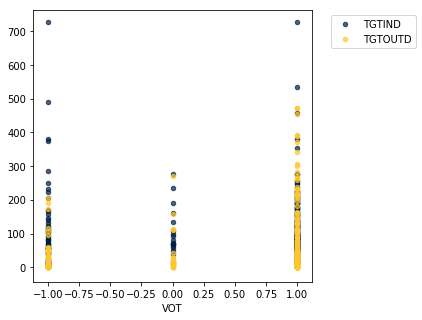

In [88]:
tab2_1 = sampledTable2.select('TGTIND', 'VOT', 'TGTOUTD')
tab2_1.scatter('VOT')

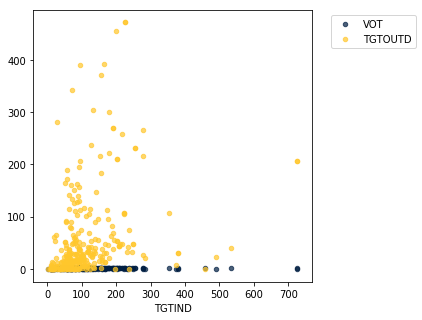

In [89]:
tab2_1.scatter('TGTIND')

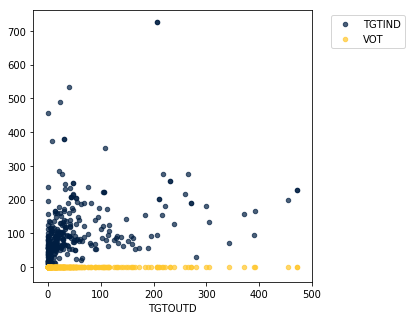

In [90]:
tab2_1.scatter('TGTOUTD')

In [97]:
tab2_2 = sampledTable2.select('SCROUTD', 'VOT', 'SCRIND')

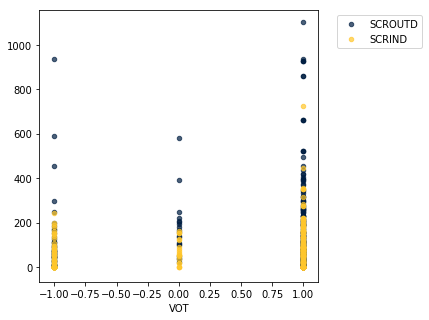

In [99]:
# *********. finding!!! see how less srcout/in have the ones that vote no
tab2_2.scatter('VOT')

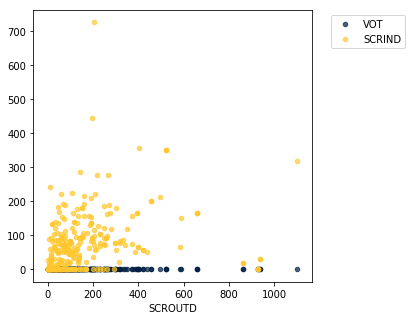

In [101]:
tab2_2.scatter('SCROUTD')

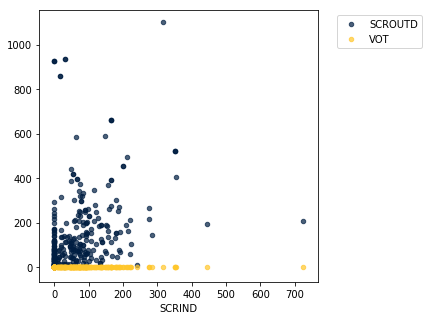

In [102]:
tab2_2.scatter('SCRIND')